<a href="https://colab.research.google.com/github/lalit527/Angular2-start/blob/master/Deep_Learning_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install fastai==0.7.0
import sys
!{sys.executable} -m pip install torchtext==0.2.3
!curl http://files.fast.ai/data/dogscats.zip --output sample_data/dogscats.zip
!unzip sample_data/dogscats.zip

In [0]:
import fastai

In [0]:
from fastai.imports import *

In [0]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [0]:
PATH = "dogscats/"
sz = 224

In [14]:
torch.cuda.is_available()

True

In [15]:
torch.backends.cudnn.enabled

True

In [16]:
os.listdir(PATH)

['valid', 'train', 'models', 'test1', 'sample']

In [17]:
os.listdir(f'{PATH}valid')

['dogs', 'cats']

In [21]:
files = os.listdir(f'{PATH}valid/cats')[20:25]
files

['cat.11112.jpg',
 'cat.5486.jpg',
 'cat.4328.jpg',
 'cat.4690.jpg',
 'cat.3068.jpg']

In [0]:
sns.set_style('whitegrid')

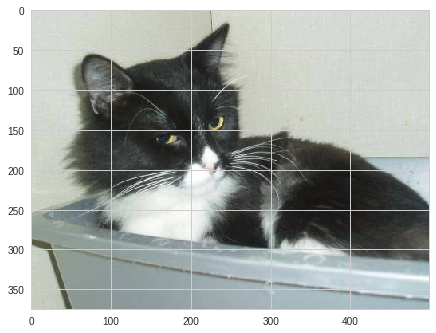

In [23]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img)

In [24]:
img.shape

(375, 499, 3)

In [25]:
img[:4, :4]

array([[[214, 219, 213],
        [214, 219, 213],
        [214, 219, 213],
        [215, 220, 214]],

       [[214, 219, 213],
        [214, 219, 213],
        [214, 219, 213],
        [215, 220, 214]],

       [[213, 218, 212],
        [213, 218, 212],
        [214, 219, 213],
        [214, 219, 213]],

       [[213, 218, 212],
        [213, 218, 212],
        [213, 218, 212],
        [214, 219, 213]]], dtype=uint8)

In [26]:
arch = resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 46628554.33it/s]


100%|██████████| 32/32 [00:14<00:00,  4.24it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.048288   0.02699    0.9915    
    1      0.041074   0.026607   0.9895    



[array([0.02661]), 0.9895]

In [27]:
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [28]:
data.classes

['cats', 'dogs']

In [29]:
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [30]:
log_preds[:10]

array([[ -0.00005,  -9.9873 ],
       [ -0.00044,  -7.72699],
       [ -0.00029,  -8.14028],
       [ -0.00022,  -8.40237],
       [ -0.0005 ,  -7.596  ],
       [ -0.00036,  -7.91976],
       [ -0.00089,  -7.02161],
       [ -0.     , -14.80229],
       [ -0.0036 ,  -5.62824],
       [ -0.19165,  -1.74639]], dtype=float32)

In [0]:
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:, 1])

In [0]:
def rand_by_mask(mask): 
  return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)

def rand_by_correct(is_correct):
  return rand_by_mask((preds == data.val_y) == is_correct)

In [0]:
def plots(ims, figsize=(12, 6), rows=1, titles=None):
  f = plt.figure(figsize=figsize)
  for i in range(len(ims)):
    sp = f.add_subplot(rows, len(ims) // rows, i+1)
    sp.axis('Off')
    if titles is not None:
      sp.set_title(titles[i], fontsize=16)
    plt.imshow(ims[i])

In [0]:
def load_img_id(ds, idx):
  return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
  imgs = [load_img_id(data.val_ds, x) for x in idxs]
  title_probs = [probs[x] for x in idxs]
  print(title)
  return plots(imgs, rows=1, titles=title_probs, figsize=(16, 8)) if len(imgs) > 0 else print('Not Found')

Correctly classified


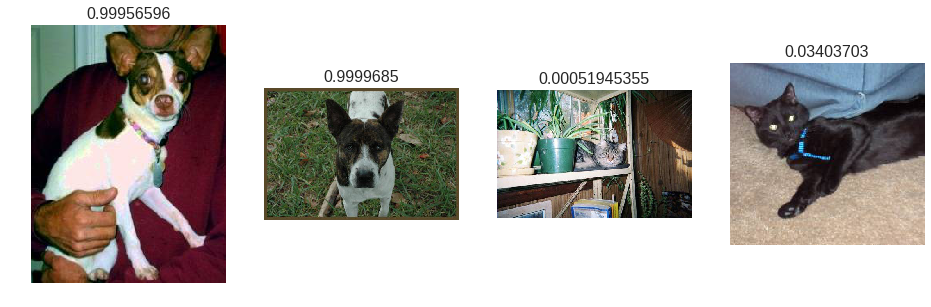

In [35]:
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


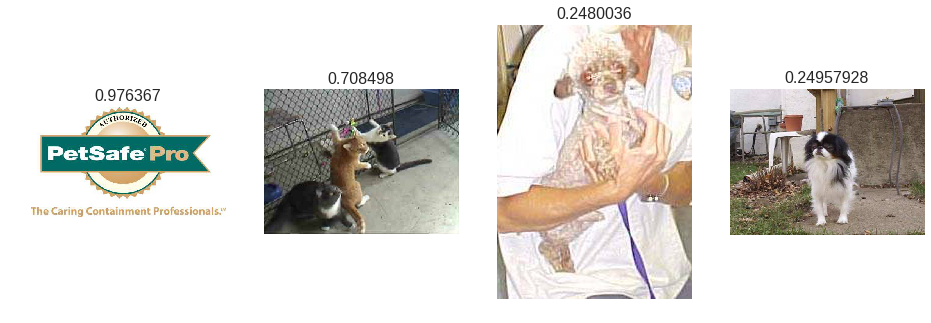

In [36]:
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [0]:
def most_by_mask(mask, mult):
  idxs = np.where(mask)[0]
  return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct):
  mult = -1 if(y==1)==is_correct else 1
  return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct cats


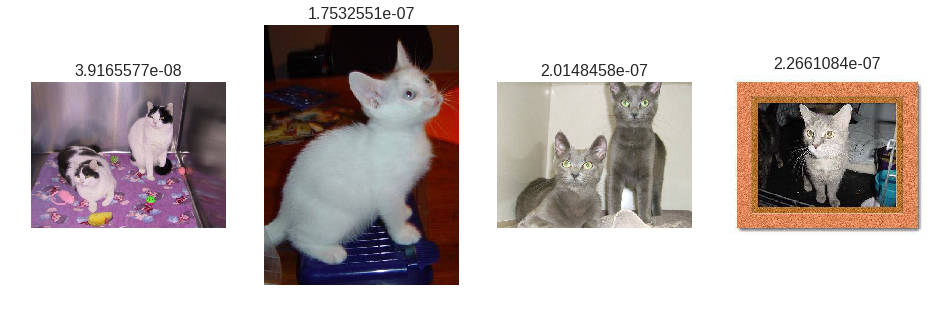

In [38]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


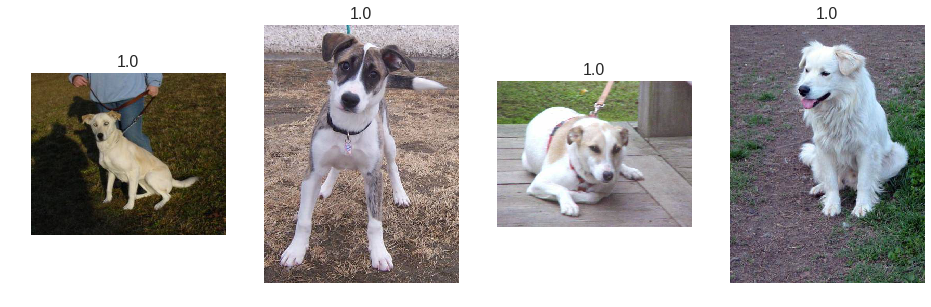

In [39]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect cats


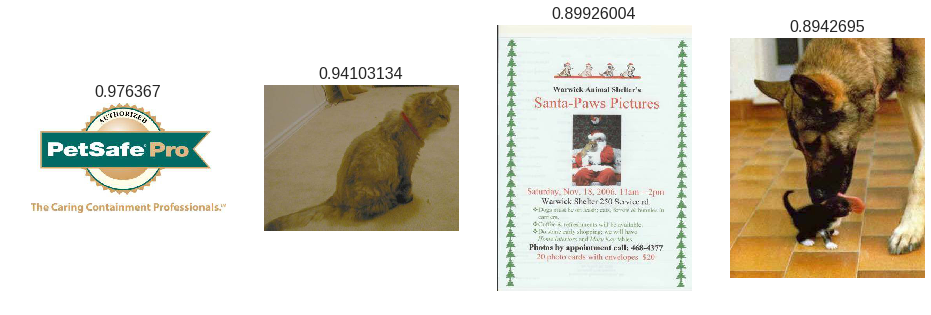

In [40]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


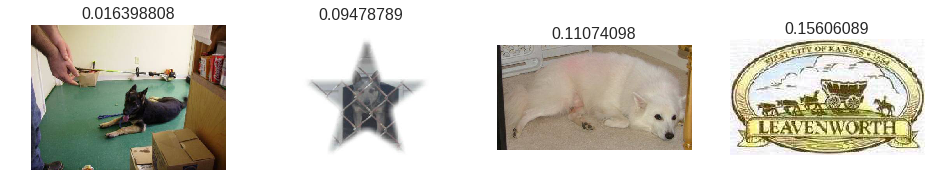

In [41]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


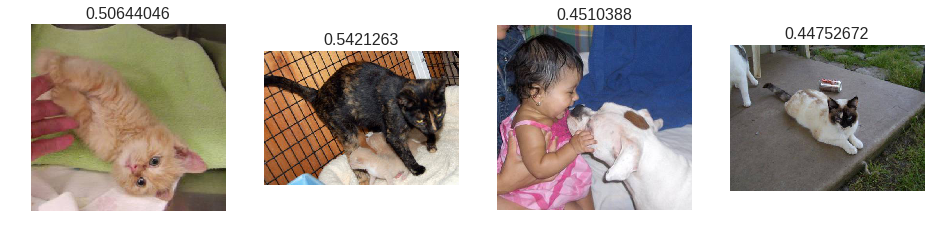

In [42]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [0]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [44]:
lrf=learn.lr_find()

 81%|████████▏ | 293/360 [00:05<00:01, 49.45it/s, loss=0.391]


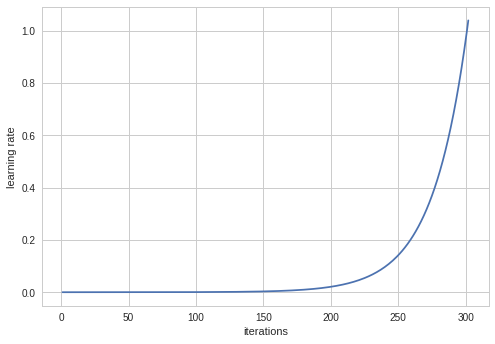

In [45]:
learn.sched.plot_lr()

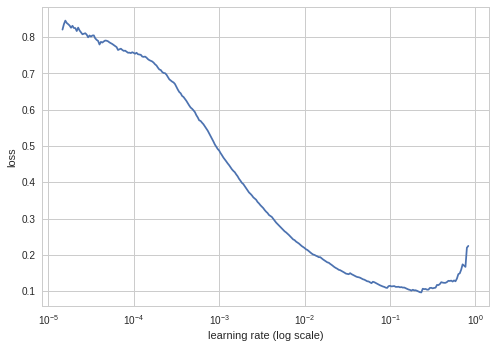

In [46]:
learn.sched.plot()

In [0]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [0]:
def get_augs():
  data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
  x, _ = next(iter(data.aug_dl))
  return data.trn_ds.denorm(x)[1]

In [0]:
ims = np.stack([get_augs() for i in range(6)])

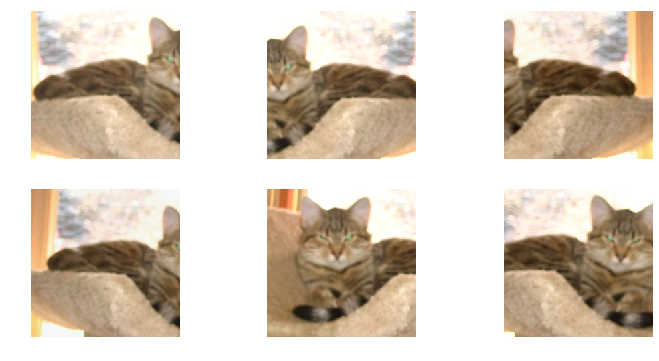

In [50]:
plots(ims, rows=2)

In [0]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [52]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy   
    0      0.054782   0.026495   0.989     



[array([0.02649]), 0.989]

In [0]:
learn.precompute=False

In [54]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.047177   0.026492   0.99      
    1      0.042521   0.026276   0.9895    
    2      0.047174   0.028218   0.9895    



[array([0.02822]), 0.9895]

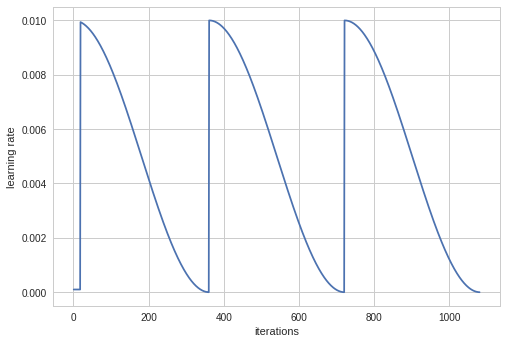

In [56]:
learn.sched.plot_lr()

In [0]:
learn.save('224_lastlayer')

In [0]:
learn.load('224_lastlayer')

In [0]:
learn.unfreeze()

In [0]:
lr=np.array([1e-4,1e-3,1e-2])

In [63]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      0.048368   0.02524    0.99      
    1      0.049714   0.02304    0.99      
    2      0.030518   0.019295   0.9925    
    3      0.033241   0.020378   0.992     
    4      0.02715    0.017979   0.993     
    5      0.019361   0.018652   0.9945    
    6      0.020183   0.018565   0.993     



[array([0.01857]), 0.993]

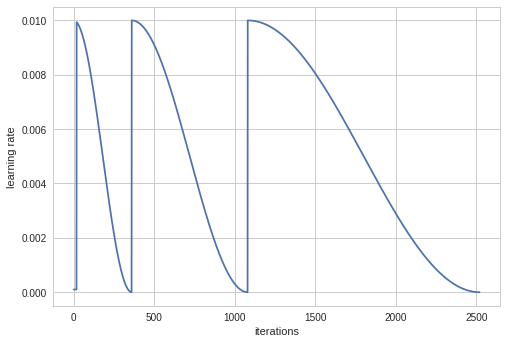

In [64]:
learn.sched.plot_lr()

In [0]:
learn.save('224_all')

In [0]:
learn.load('224_all')

In [67]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [68]:
accuracy_np(probs, y)

0.9955

In [0]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[996   4]
 [  5 995]]


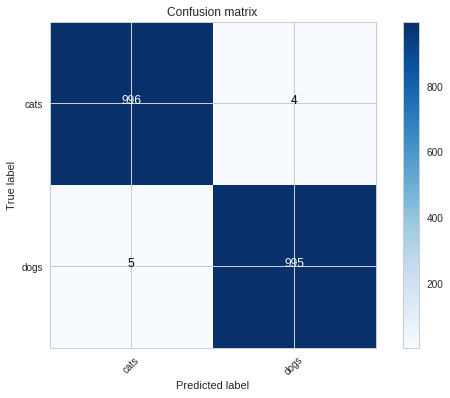

In [71]:
plot_confusion_matrix(cm, data.classes)

Most incorrect cats


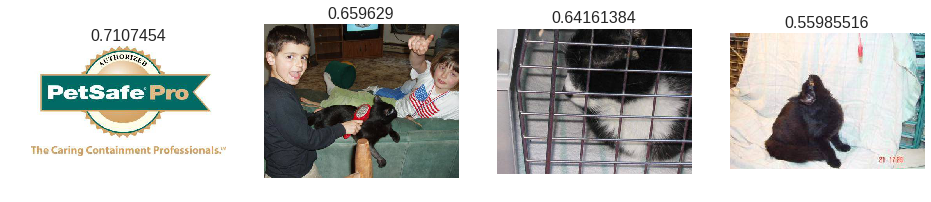

In [72]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


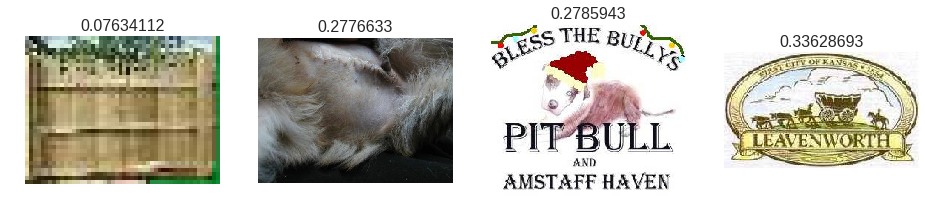

In [73]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")